## Airbnb Data Cleaning

Liqin Zhang - lz2809

In [612]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
print('all import succeed')

all import succeed


In [613]:
raw_df = pd.read_csv('E:\Columbia University\Courses\Big-Data Analytics\listings.csv')
print(f"Import {len(raw_df)} Airbnb listings")

Import 32877 Airbnb listings


C:\Users\51370\anaconda3\envs\bigdata\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (58,59) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [614]:
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20211102175612,2021-11-03,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/e704a...,https://a0.muscache.com/im/pictures/user/e704a...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,Culver City,Other Cities,33.98301,-118.38607,Entire condominium (condo),Entire home/apt,6,NaN,2 baths,2.0,3.0,"[""Shampoo"", ""Free parking on premises"", ""Cable...",$115.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,0,0,0,193,2021-11-03,2,0,0,2011-08-15,2016-05-15,4.00,5.00,5.00,3.00,4.00,5.0,4.00,NaN,f,1,1,0,0,0.02
1,2708,https://www.airbnb.com/rooms/2708,20211102175612,2021-11-03,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,"Run Runyon Canyon, Our Gym & Sauna Open <br />...","Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,Chas.,2008-09-16,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/d17cf...,https://a0.muscache.com/im/pictures/user/d17cf...,Hollywood,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Los Angeles, California, United States",Hollywood,City of Los Angeles,34.09625,-118.34605,Private room in rental unit,Private room,1,NaN,1 shared bath,1.0,1.0,"[""Coffee maker"", ""Shampoo"", ""Free parking on p...",$89.00,30,366,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,6,7,25,300,2021-11-03,33,6,1,2017-12-29,2021-11-01,4.82,4.79,4.91,5.00,4.97,5.0,4.85,NaN,t,2,0,2,0,0.70
2,2732,https://www.airbnb.com/rooms/2732,20211102175612,2021-11-03,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082974/0f74c...,3041,https://www.airbnb.com/users/show/3041,Yoga Priestess,2008-09-17,"Santa Monica, California, United States",I have been teaching yoga and meditation for 3...,within an hour,100%,33%,t,https://a0.muscache.com/im/users/3041/profile_...,https://a0.muscache.com/im/users/3041/profile_...,Santa Monica,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Santa Monica, California, United States",Santa Monica,Other Cities,34.00440,-118.48095,Private room in rental unit,Private room,1,NaN,1 private bath,1.0,1.0,"[""Free street parking""

### Drop unused feature columns

In [615]:
drop_features = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(drop_features, axis=1)

In [616]:
df.isna().sum()

id                                                  0
host_since                                         26
host_response_time                              10659
host_response_rate                              10659
host_acceptance_rate                            10265
host_is_superhost                                  26
host_listings_count                                26
host_total_listings_count                          26
host_has_profile_pic                               26
host_identity_verified                             26
neighbourhood                                   12921
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                   

In [617]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'license'], axis=1, inplace=True)
df.set_index('id', inplace=True) 

In [618]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

26


,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6900415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Los Angeles, California, United States",Mar Vista,34.00105,-118.43665,Entire residential home,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Kitchen"", ""Free parking on premises"", ""Washe...",$99.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,f,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
10034835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rancho Park,34.03157,-118.41318,Private room in rental unit,Private room,3,NaN,1 bath,1.0,1.0,"[""Iron"", ""Kitchen"", ""Pool"", ""Heating"", ""Free p...",$41.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,2,0,0,2015-12-18,2015-12-19,0.00,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,0.03
10826370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Los Angeles, California, United States",West Hollywood,34.08277,-118.37643,Entire rental unit,Entire home/apt,3,NaN,1 bath,1.0,1.0,"[""Babysitter recommendations"", ""Coffee maker"",...",$159.00,31,1125,31.0,31.0,1125.0,1125.0,31.0,1125.0,NaN,t,0,0,1,276,31,6,1,2016-02-02,2021-10-26,4.86,4.82,4.82,4.96,4.96,4.96,4.75,f,2,2,0,0,0.44
11872676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Los Angeles, California, United States",San Pedro,33.70679,-118.29130,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Coffee maker"", ""Shampoo"", ""Cable TV"", ""Dishe...",$88.00,30,365,30.0,30.0,365.0,365.0,30.0,365.0,NaN,t,0,0,1,3,24,0,0,2018-08-04,2020-09-30,4.88,5.00,4.92,5.00,5.00,4.86,4.82,f,1,1,0,0,0.61
33137508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Los Angeles, California, United States",Mid-Wilshire,34.05641,-118.36375,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Coffee maker"", ""Shampoo"", ""Free parking on p...",$85.00,300,450,300.0,300.0,450.0,450.0,300.0,450.0,NaN,t,0,0,0,0,8,0,0,2019-04-23,2019-10-07,5.00,5.00,5.00,5.00,5.00,5.00,5.00,t,1,1,0,0,0.26


In [619]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


In [620]:
lat_long = df[['latitude', 'longitude']]

In [621]:
df.drop(['latitude', 'longitude', 'neighbourhood'], axis=1, inplace=True)

In [622]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

1762

In [623]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

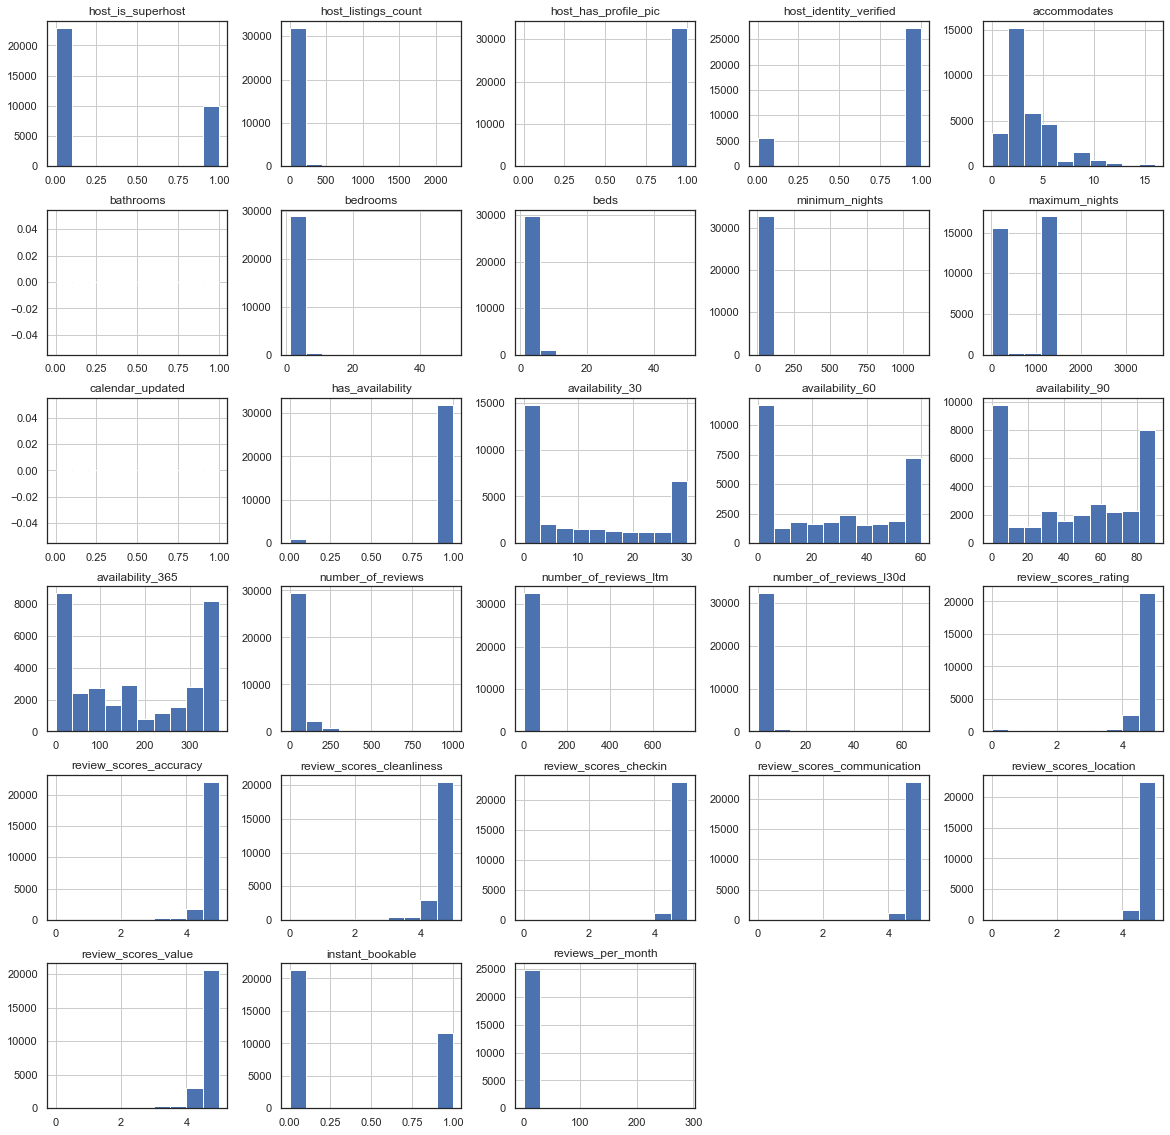

In [624]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

### Description of each column:
- experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the London borough the property is in
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- minimum_nights - the minimum length of stay
- maximum_nights - the maximum length of stay
- calendar_updated - when the host last updated the calendar
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to - message the host first and wait to be accepted)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- reviews_per_month - calculated field of the average number of reviews left by guest each month

### Clean specific columns


In [625]:
df.amenities[:1].values

array(['["Shampoo", "Free parking on premises", "Cable TV", "Washer", "Elevator", "Gym", "Long term stays allowed", "Essentials", "Kitchen", "First aid kit", "Hair dryer", "Air conditioning", "Heating", "TV with standard cable", "Hangers", "Indoor fireplace", "Fire extinguisher", "Iron", "Pool", "Hot tub", "Dedicated workspace", "Smoke alarm", "Carbon monoxide alarm", "Wifi", "Dryer"]'],
      dtype=object)

In [626]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [627]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [628]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('] [', '')
amenities_list_string = amenities_list_string.replace('\\', '')
amenities_list_string = amenities_list_string.replace(' u2013', '')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'kitchenaid refrigerator',
 'Clothing storage: dresser and closetFree parking on premises',
 'WasherBathroom essentials',
 '85 HDTV with Netflix',
 '36 TV with Roku',
 "dove or what's available body soap",
 'General Electric Stainless Steel refrigerator',
 'Samsung gas oven stainless steel oven',
 'Beach essentials',
 'Okeefe & Merritt (Antique Collectible Restored ) gas stove',
 'Wifi 6000 Mbps',
 'convention Microwave oven ovenSmoke alarm',
 'Shared saunaHeating',
 'Whirlpool refrigeratorCooking basics',
 'I have some lovely products. body soap',
 'Beekman shampoo',
 'LG stove',
 'DryerAiwaa Bluetooth sound system',
 'TVPortable stove top by CUSIMAX stainless steel electric stove',
 'Bertazoni stainless steel oven',
 'Harmon & Kardon sound system with Bluetooth and aux',
 'Ultimate Ears Bluetooth sound system',
 'Lounge chairs',
 'OvenPrivate patio or balcony',
 'LockboxPrivate patio or balcony',
 'Hair dryerFirst aid kit',
 'Dedicated workspace: office chair and table',
 'for guest

In [629]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\Users\51370\AppData\Local\Temp/ipykernel_33432/1426836555.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1


In [630]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'nature_and_views', 'breakfast', 'child_friendly', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [631]:
df.columns[40:]

Index(['bbq', 'balcony', 'bed_linen', 'tv', 'coffee_machine', 'cooking_basics',
       'white_goods', 'elevator', 'gym', 'parking', 'outdoor_space',
       'host_greeting', 'hot_tub_sauna_or_pool', 'internet', 'long_term_stays',
       'private_entrance'],
      dtype='object')

In [632]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [633]:
df.drop('calendar_updated', axis=1, inplace=True)

In [634]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [635]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 24.1%
Null values in 'review_scores_rating': 24.1%


In [636]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

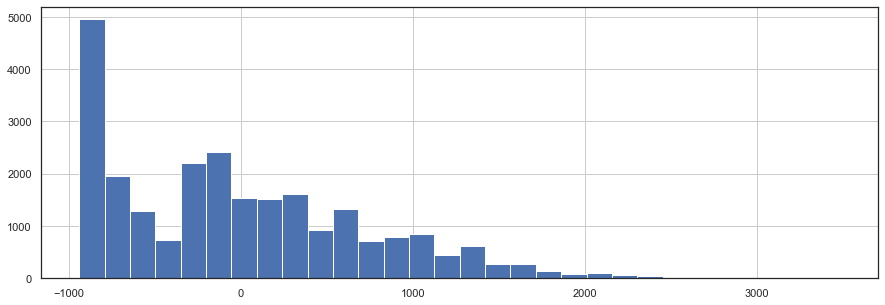

In [637]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [638]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [639]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [640]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

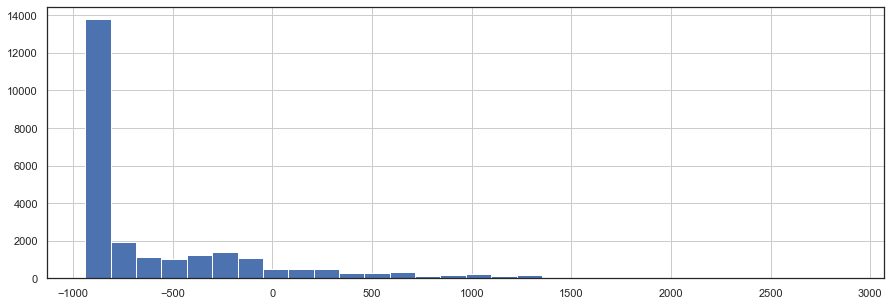

In [641]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [642]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [643]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

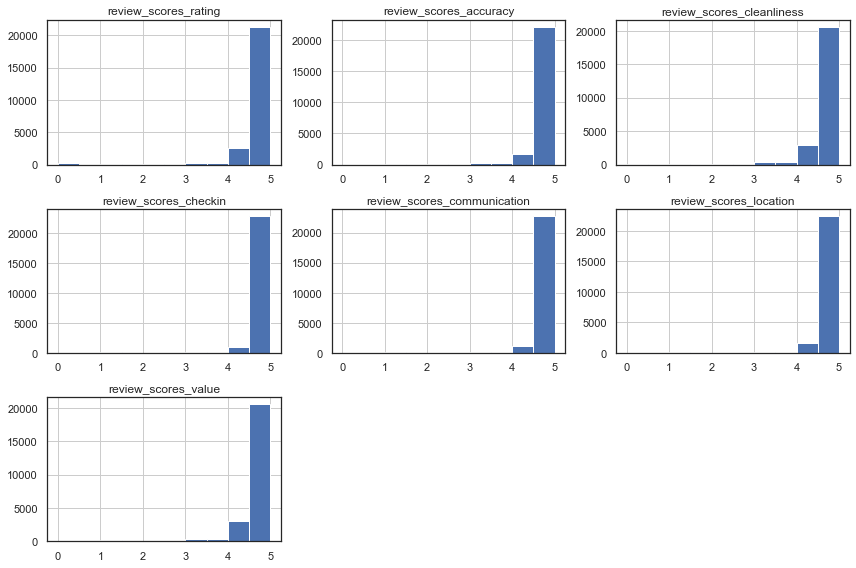

In [644]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [645]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [646]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [647]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

## Time series data analysis

In [648]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [649]:
ts_host_since = pd.DataFrame(df.set_index('host_since'))

In [650]:
ts_first_review = pd.DataFrame(df.set_index('first_review'))

In [651]:
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [652]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]


,host_since,host_listings_count
id,,
51829195,2020-07-28,437.0
49240972,2018-01-31,441.0
48194790,2019-10-24,460.0
48997253,2017-05-18,586.0
49133182,2019-05-22,662.0
42712422,2015-11-02,1106.0
46731485,2018-02-22,1142.0
46459707,2016-12-16,1987.0
51079604,2020-09-23,2232.0


C:\Users\51370\anaconda3\envs\bigdata\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\51370\anaconda3\envs\bigdata\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


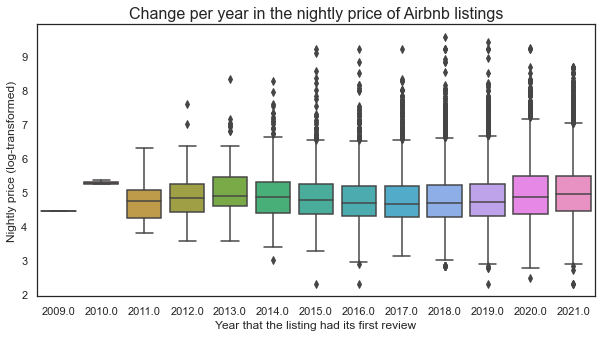

In [653]:
plt.figure(figsize=(10,5))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings', fontsize=16)
plt.show()

In [654]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
51829195,2020-07-28,437.0
49240972,2018-01-31,441.0
48194790,2019-10-24,460.0
48997253,2017-05-18,586.0
49133182,2019-05-22,662.0
42712422,2015-11-02,1106.0
46731485,2018-02-22,1142.0
46459707,2016-12-16,1987.0
51079604,2020-09-23,2232.0


In [655]:
print("Mean nightly price of listings in each year on Airbnb")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb
first_review
2009-01-01     85.00
2010-01-01    198.33
2011-01-01    135.03
2012-01-01    182.23
2013-01-01    216.53
2014-01-01    212.50
2015-01-01    198.35
2016-01-01    182.66
2017-01-01    193.51
2018-01-01    200.20
2019-01-01    190.27
2020-01-01    249.78
2021-01-01    229.77
Name: price, dtype: float64


In [656]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [657]:
df.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,reviews_per_month,check_in_24h,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance
count,32851.000000,32851.000000,32851.000000,32851.000000,32877.000000,0.0,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,24958.000000,0.0,25719.0,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000,32877.000000
mean,0.303278,41.401753,0.994155,0.828620,3.648599,NaN,1.608267,2.058764,260.460383,20.216291,655.394075,0.970709,44.173647,34.293153,7.371749,0.711744,0.353408,2.399320,NaN,1.0,0.212702,0.285640,0.492198,0.851811,0.546552,0.569273,0.766524,0.157496,0.140585,0.852876,0.164887,0.117590,0.285488,0.976154,0.897679,0.491407
std,0.459681,221.140853,0.076227,0.376846,2.562002,NaN,1.089468,1.523116,722.505994,34.105992,501.096583,0.168624,35.019742,69.248578,16.818226,1.679529,0.478035,5.853897,NaN,0.0,0.409225,0.451726,0.499947,0.355292,0.497836,0.495185,0.423049,0.364273,0.347598,0.354235,0.371084,0.322127,0.451654,0.152573,0.303074,0.499934
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,NaN,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,2.000000,NaN,1.000000,1.000000,79.000000,2.000000,90.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.250000,NaN,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.000000,2.000000,1.000000,1.000000,3.000000,NaN,1.000000,2.000000,125.000000,30.000000,1125.000000,1.000000,47.000000,6.000000,1.000000,0.000000,0.000000,0.890000,NaN,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,7.000000,1.000000,1.000000,4.000000,NaN,2.000000,2.000000,225.000000,30.000000,1125.000000,1.000000,80.000000,34.000000,6.000000,1.000000,1.000000,2.650000,NaN,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,2232.000000,1.000000,1.000000,16.000000,NaN,50.000000,50.000000,25000.000000,1125.000000,3650.000000,1.000000,90.000000,998.000000,760.000000,68.000000,1.000000,289.170000,NaN,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


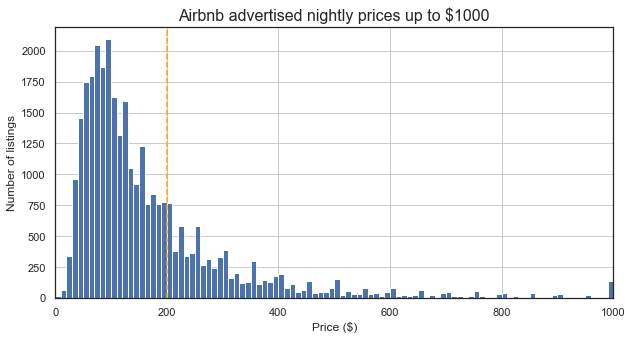

In [658]:
plt.figure(figsize=(10,5))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [659]:
df.loc[df.price <= 10, 'price'] = 10
df.loc[df.price >= 1000, 'price'] = 1000

In [660]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 41
31% of listings are from hosts with one listing.


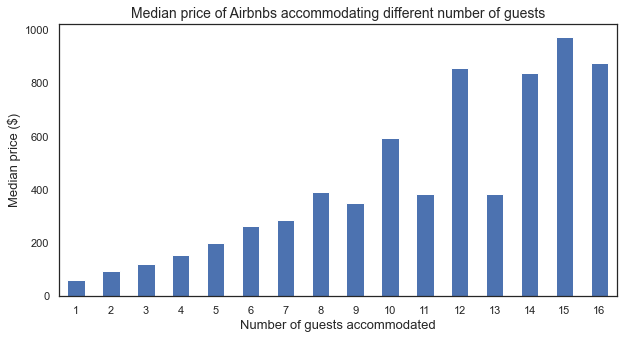

In [661]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

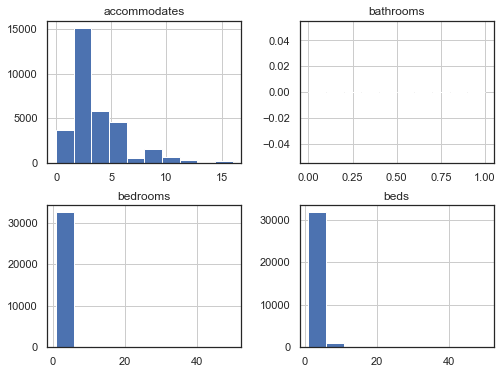

In [662]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

## Modeling

In [663]:
transformed_df = pd.get_dummies(df)

In [664]:
def multi_collinearity_heatmap(df, title, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    ax.set_title(title, fontsize=30)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [665]:
# multi_collinearity_heatmap(transformed_df, figsize=(20,20))

In [666]:
# multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

In [667]:
import re

# Dropping collinear features
to_drop = []
regex1 = '^host_response_rate_\\d+%$'
regex2 = '^neighbourhood_cleansed_.+$'
regex3 = '^check_in_.+$'
regex4 = '^time_since_.+$'
for column in transformed_df:
    if re.match(regex1, column) or re.match(regex2, column) or re.match(regex3, column) or re.match(regex4, column):
        to_drop.append(column)
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))
transformed_df.drop(to_drop, axis=1, inplace=True)

# to_drop = ['host_response_rate_11%', 'host_response_rate_13%', 'host_response_rate_14%', 'host_response_rate_15%', 
#            'host_response_rate_17%', 'host_response_rate_20%', 'host_response_rate_21%', 'host_response_rate_22%', 
#            'host_response_rate_23%', 'host_response_rate_25%', 'host_response_rate_28%', 'host_response_rate_29%', 
#            'host_response_rate_30%', 'host_response_rate_32%', 'host_response_rate_33%', 'host_response_rate_34%', 
#            'host_response_rate_35%', 'host_response_rate_36%', 'host_response_rate_38%', 'host_response_rate_40%', 
#            'host_response_rate_41%', 'host_response_rate_42%', 'host_response_rate_43%', 'host_response_rate_44%', 
#            'host_response_rate_45%', 'host_response_rate_46%', 'host_response_rate_47%', 'host_response_rate_48%', 
#            'host_response_rate_49%', 'host_response_rate_5%', 'host_response_rate_50%', 'host_response_rate_51%', 
#            'host_response_rate_52%', 'host_response_rate_53%', 'host_response_rate_54%', 'host_response_rate_55%', 
#            'host_response_rate_56%', 'host_response_rate_57%', 'host_response_rate_58%', 'host_response_rate_6%', 
#            'host_response_rate_60%', 'host_response_rate_61%', 'host_response_rate_62%', 'host_response_rate_63%', 
#            'host_response_rate_64%', 'host_response_rate_65%', 'host_response_rate_67%', 'host_response_rate_68%', 
#            'host_response_rate_69%', 'host_response_rate_7%', 'host_response_rate_70%', 'host_response_rate_71%', 
#            'host_response_rate_72%', 'host_response_rate_73%', 'host_response_rate_74%', 'host_response_rate_75%', 
#            'host_response_rate_76%', 'host_response_rate_77%', 'host_response_rate_78%', 'host_response_rate_79%', 
#            'host_response_rate_80%', 'host_response_rate_81%', 'host_response_rate_82%', 'host_response_rate_83%', 
#            'host_response_rate_84%', 'host_response_rate_85%', 'host_response_rate_86%', 'host_response_rate_87%', 
#            'host_response_rate_88%', 'host_response_rate_89%', 'host_response_rate_9%', 'host_response_rate_90%', 
#            'host_response_rate_91%', 'host_response_rate_92%', 'host_response_rate_93%', 'host_response_rate_94%', 
#            'host_response_rate_95%', 'host_response_rate_96%', 'host_response_rate_97%', 'host_response_rate_98%', 
#            'host_response_rate_99%', 'neighbourhood_cleansed_Allerton', 'neighbourhood_cleansed_Arden Heights', 
#            'neighbourhood_cleansed_Arrochar', 'neighbourhood_cleansed_Arverne', 'neighbourhood_cleansed_Astoria', 
#            'neighbourhood_cleansed_Bath Beach', 'neighbourhood_cleansed_Battery Park City', 
#            'neighbourhood_cleansed_Bay Ridge', 'neighbourhood_cleansed_Bay Terrace', 
#            'neighbourhood_cleansed_Baychester', 'neighbourhood_cleansed_Bayside', 'neighbourhood_cleansed_Bayswater', 
#            'neighbourhood_cleansed_Bedford-Stuyvesant', 'neighbourhood_cleansed_Belle Harbor', 
#            'neighbourhood_cleansed_Bellerose', 'neighbourhood_cleansed_Belmont', 'neighbourhood_cleansed_Bensonhurst',
#            'neighbourhood_cleansed_Bergen Beach', 'neighbourhood_cleansed_Boerum Hill', 
#            'neighbourhood_cleansed_Borough Park', 'neighbourhood_cleansed_Breezy Point',
#            'neighbourhood_cleansed_Briarwood', 'neighbourhood_cleansed_Brighton Beach', 
#            'neighbourhood_cleansed_Bronxdale', 'neighbourhood_cleansed_Brooklyn Heights', 
#            'neighbourhood_cleansed_Brownsville', "neighbourhood_cleansed_Bull's Head", 
#            'neighbourhood_cleansed_Bushwick', 'neighbourhood_cleansed_Cambria Heights', 'neighbourhood_cleansed_Canarsie', 'neighbourhood_cleansed_Carroll Gardens', 'neighbourhood_cleansed_Castle Hill',
#            'neighbourhood_cleansed_Castleton Corners', 'neighbourhood_cleansed_Chelsea', 'neighbourhood_cleansed_Chelsea, Staten Island', 'neighbourhood_cleansed_Chinatown', 'neighbourhood_cleansed_City Island', 'neighbourhood_cleansed_Civic Center', 'neighbourhood_cleansed_Claremont Village', 
#            'neighbourhood_cleansed_Clason Point', 'neighbourhood_cleansed_Clifton', 'neighbourhood_cleansed_Clinton Hill', 'neighbourhood_cleansed_Co-op City', 'neighbourhood_cleansed_Cobble Hill', 'neighbourhood_cleansed_College Point', 'neighbourhood_cleansed_Columbia St', 'neighbourhood_cleansed_Concord', 'neighbourhood_cleansed_Concourse', 
#            'neighbourhood_cleansed_Concourse Village', 'neighbourhood_cleansed_Coney Island', 'neighbourhood_cleansed_Corona', 'neighbourhood_cleansed_Country Club', 'neighbourhood_cleansed_Crown Heights', 'neighbourhood_cleansed_Cypress Hills', 'neighbourhood_cleansed_DUMBO', 'neighbourhood_cleansed_Ditmars Steinway',
#            'neighbourhood_cleansed_Dongan Hills', 'neighbourhood_cleansed_Douglaston', 'neighbourhood_cleansed_Downtown Brooklyn', 'neighbourhood_cleansed_Dyker Heights', 'neighbourhood_cleansed_East Elmhurst', 'neighbourhood_cleansed_East Flatbush', 'neighbourhood_cleansed_East Harlem', 'neighbourhood_cleansed_East Morrisania', 'neighbourhood_cleansed_East New York', 'neighbourhood_cleansed_East Village', 
#            'neighbourhood_cleansed_Eastchester', 'neighbourhood_cleansed_Edenwald', 'neighbourhood_cleansed_Edgemere', 'neighbourhood_cleansed_Elmhurst', 'neighbourhood_cleansed_Eltingville', 'neighbourhood_cleansed_Emerson Hill', 'neighbourhood_cleansed_Far Rockaway', 'neighbourhood_cleansed_Fieldston', 'neighbourhood_cleansed_Financial District', 'neighbourhood_cleansed_Flatbush', 'neighbourhood_cleansed_Flatiron District', 'neighbourhood_cleansed_Flatlands', 'neighbourhood_cleansed_Flushing',
#            'neighbourhood_cleansed_Fordham', 'neighbourhood_cleansed_Forest Hills', 'neighbourhood_cleansed_Fort Greene', 'neighbourhood_cleansed_Fort Hamilton', 'neighbourhood_cleansed_Fort Wadsworth', 'neighbourhood_cleansed_Fresh Meadows', 'neighbourhood_cleansed_Gerritsen Beach', 'neighbourhood_cleansed_Glendale', 'neighbourhood_cleansed_Gowanus', 'neighbourhood_cleansed_Gramercy', 'neighbourhood_cleansed_Graniteville',
#            'neighbourhood_cleansed_Grant City', 'neighbourhood_cleansed_Gravesend', 'neighbourhood_cleansed_Great Kills', 'neighbourhood_cleansed_Greenpoint', 'neighbourhood_cleansed_Greenwich Village', 'neighbourhood_cleansed_Grymes Hill', 'neighbourhood_cleansed_Harlem', "neighbourhood_cleansed_Hell's Kitchen", 'neighbourhood_cleansed_Highbridge', 'neighbourhood_cleansed_Hollis', 'neighbourhood_cleansed_Holliswood', 'neighbourhood_cleansed_Howard Beach', 'neighbourhood_cleansed_Howland Hook', 'neighbourhood_cleansed_Huguenot', 'neighbourhood_cleansed_Hunts Point', 'neighbourhood_cleansed_Inwood', 
#            'neighbourhood_cleansed_Jackson Heights', 'neighbourhood_cleansed_Jamaica', 'neighbourhood_cleansed_Jamaica Estates', 'neighbourhood_cleansed_Jamaica Hills', 'neighbourhood_cleansed_Kensington', 'neighbourhood_cleansed_Kew Gardens', 'neighbourhood_cleansed_Kew Gardens Hills', 'neighbourhood_cleansed_Kingsbridge', 'neighbourhood_cleansed_Kips Bay', 'neighbourhood_cleansed_Laurelton', 'neighbourhood_cleansed_Lighthouse Hill', 'neighbourhood_cleansed_Little Italy', 'neighbourhood_cleansed_Little Neck', 'neighbourhood_cleansed_Long Island City', 'neighbourhood_cleansed_Longwood', 'neighbourhood_cleansed_Lower East Side', 'neighbourhood_cleansed_Manhattan Beach', 'neighbourhood_cleansed_Marble Hill', 'neighbourhood_cleansed_Mariners Harbor', 'neighbourhood_cleansed_Maspeth', 'neighbourhood_cleansed_Melrose', 'neighbourhood_cleansed_Middle Village', 'neighbourhood_cleansed_Midland Beach', 'neighbourhood_cleansed_Midtown', 'neighbourhood_cleansed_Midwood', 'neighbourhood_cleansed_Mill Basin', 'neighbourhood_cleansed_Morningside Heights', 'neighbourhood_cleansed_Morris Heights', 'neighbourhood_cleansed_Morris Park', 'neighbourhood_cleansed_Morrisania', 'neighbourhood_cleansed_Mott Haven', 'neighbourhood_cleansed_Mount Eden', 'neighbourhood_cleansed_Mount Hope', 'neighbourhood_cleansed_Murray Hill', 'neighbourhood_cleansed_Navy Yard', 'neighbourhood_cleansed_Neponsit', 'neighbourhood_cleansed_New Brighton', 'neighbourhood_cleansed_New Dorp', 'neighbourhood_cleansed_New Dorp Beach', 'neighbourhood_cleansed_New Springville', 'neighbourhood_cleansed_NoHo', 'neighbourhood_cleansed_Nolita', 'neighbourhood_cleansed_North Riverdale', 'neighbourhood_cleansed_Norwood', 'neighbourhood_cleansed_Oakwood', 'neighbourhood_cleansed_Olinville', 'neighbourhood_cleansed_Ozone Park', 'neighbourhood_cleansed_Park Slope', 'neighbourhood_cleansed_Parkchester', 'neighbourhood_cleansed_Pelham Bay', 'neighbourhood_cleansed_Pelham Gardens', 'neighbourhood_cleansed_Port Morris', 'neighbourhood_cleansed_Port Richmond', "neighbourhood_cleansed_Prince's Bay", 'neighbourhood_cleansed_Prospect Heights', 'neighbourhood_cleansed_Prospect-Lefferts Gardens', 'neighbourhood_cleansed_Queens Village', 'neighbourhood_cleansed_Randall Manor', 'neighbourhood_cleansed_Red Hook', 'neighbourhood_cleansed_Rego Park', 'neighbourhood_cleansed_Richmond Hill', 'neighbourhood_cleansed_Richmondtown', 'neighbourhood_cleansed_Ridgewood', 'neighbourhood_cleansed_Riverdale', 'neighbourhood_cleansed_Rockaway Beach', 'neighbourhood_cleansed_Roosevelt Island', 'neighbourhood_cleansed_Rosebank', 'neighbourhood_cleansed_Rosedale', 'neighbourhood_cleansed_Rossville', 'neighbourhood_cleansed_Schuylerville', 'neighbourhood_cleansed_Sea Gate', 'neighbourhood_cleansed_Sheepshead Bay', 'neighbourhood_cleansed_Shore Acres', 'neighbourhood_cleansed_Silver Lake', 'neighbourhood_cleansed_SoHo', 'neighbourhood_cleansed_Soundview', 'neighbourhood_cleansed_South Beach', 'neighbourhood_cleansed_South Ozone Park', 'neighbourhood_cleansed_South Slope', 'neighbourhood_cleansed_Springfield Gardens', 'neighbourhood_cleansed_Spuyten Duyvil', 'neighbourhood_cleansed_St. Albans', 'neighbourhood_cleansed_St. George', 'neighbourhood_cleansed_Stapleton', 'neighbourhood_cleansed_Stuyvesant Town', 'neighbourhood_cleansed_Sunnyside', 'neighbourhood_cleansed_Sunset Park', 'neighbourhood_cleansed_Theater District', 'neighbourhood_cleansed_Throgs Neck', 'neighbourhood_cleansed_Todt Hill', 'neighbourhood_cleansed_Tompkinsville', 'neighbourhood_cleansed_Tottenville', 'neighbourhood_cleansed_Tremont', 'neighbourhood_cleansed_Tribeca', 'neighbourhood_cleansed_Two Bridges', 'neighbourhood_cleansed_Unionport', 'neighbourhood_cleansed_University Heights', 'neighbourhood_cleansed_Upper East Side', 'neighbourhood_cleansed_Upper West Side', 'neighbourhood_cleansed_Van Nest', 'neighbourhood_cleansed_Vinegar Hill', 'neighbourhood_cleansed_Wakefield', 'neighbourhood_cleansed_Washington Heights', 'neighbourhood_cleansed_West Brighton', 'neighbourhood_cleansed_West Farms', 'neighbourhood_cleansed_West Village', 'neighbourhood_cleansed_Westchester Square', 'neighbourhood_cleansed_Westerleigh', 'neighbourhood_cleansed_Whitestone', 'neighbourhood_cleansed_Williamsbridge', 'neighbourhood_cleansed_Williamsburg', 'neighbourhood_cleansed_Windsor Terrace', 'neighbourhood_cleansed_Woodhaven', 'neighbourhood_cleansed_Woodlawn', 'neighbourhood_cleansed_Woodrow', 'neighbourhood_cleansed_Woodside', 'property_type_House', 'property_type_Other', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Shared room', 'bathrooms_text_0 baths', 'bathrooms_text_0 shared baths', 'bathrooms_text_1 bath', 'bathrooms_text_1 private bath', 'bathrooms_text_1 shared bath', 'bathrooms_text_1.5 baths', 'bathrooms_text_1.5 shared baths', 'bathrooms_text_2 baths', 'bathrooms_text_2 shared baths', 'bathrooms_text_2.5 baths', 'bathrooms_text_2.5 shared baths', 'bathrooms_text_3 baths', 'bathrooms_text_3 shared baths', 'bathrooms_text_3.5 baths', 'bathrooms_text_3.5 shared baths', 'bathrooms_text_4 baths', 'bathrooms_text_4 shared baths', 'bathrooms_text_4.5 baths', 'bathrooms_text_4.5 shared baths', 'bathrooms_text_5 baths', 'bathrooms_text_5.5 baths', 'bathrooms_text_6 baths', 'bathrooms_text_6 shared baths', 'bathrooms_text_6.5 baths', 'bathrooms_text_7 baths', 'bathrooms_text_7.5 baths', 'bathrooms_text_8 baths', 'bathrooms_text_Half-bath', 'bathrooms_text_Private half-bath', 'bathrooms_text_Shared half-bath']
# to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

# transformed_df.drop(to_drop, axis=1, inplace=True)

C:\Users\51370\AppData\Local\Temp/ipykernel_33432/3413172762.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


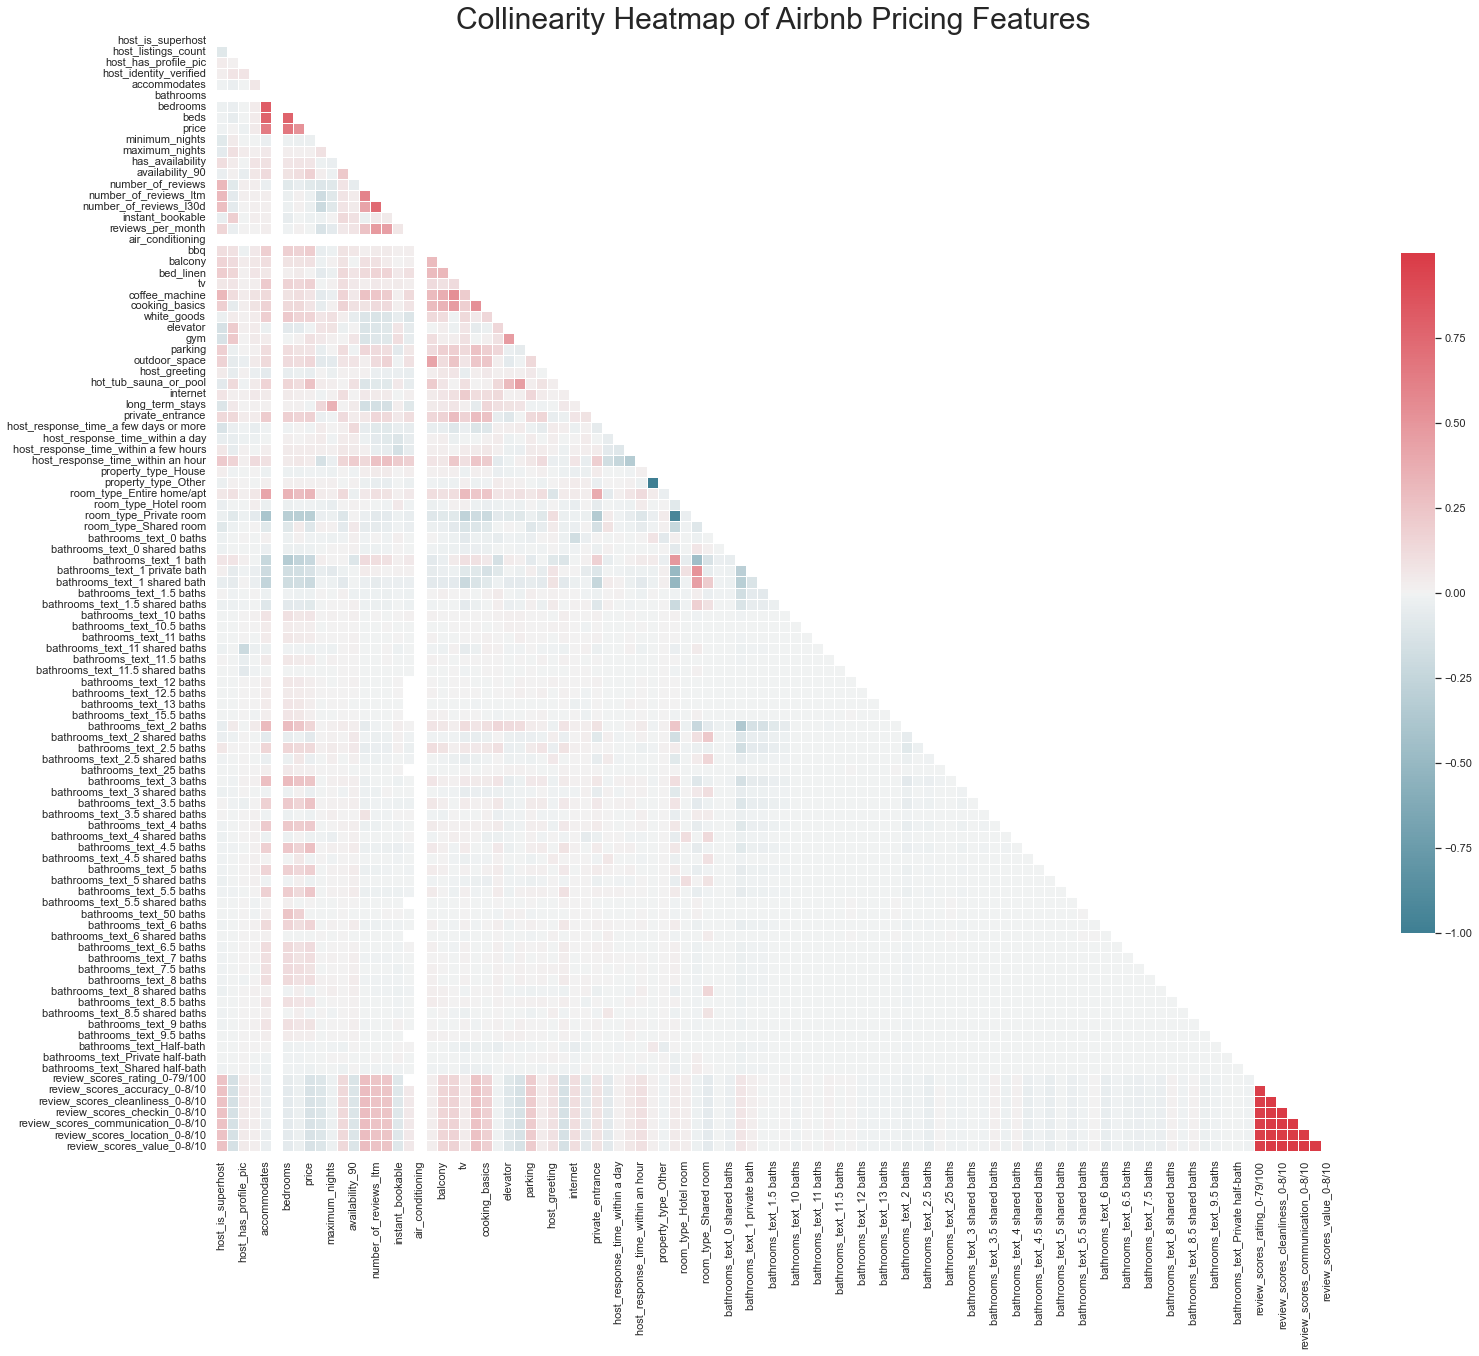

In [668]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,25), title="Collinearity Heatmap of Airbnb Pricing Features")

In [178]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price']

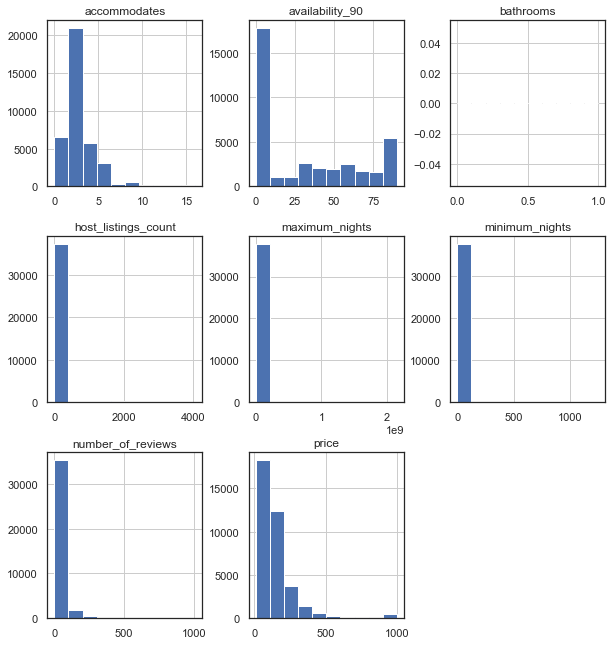

In [179]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [180]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

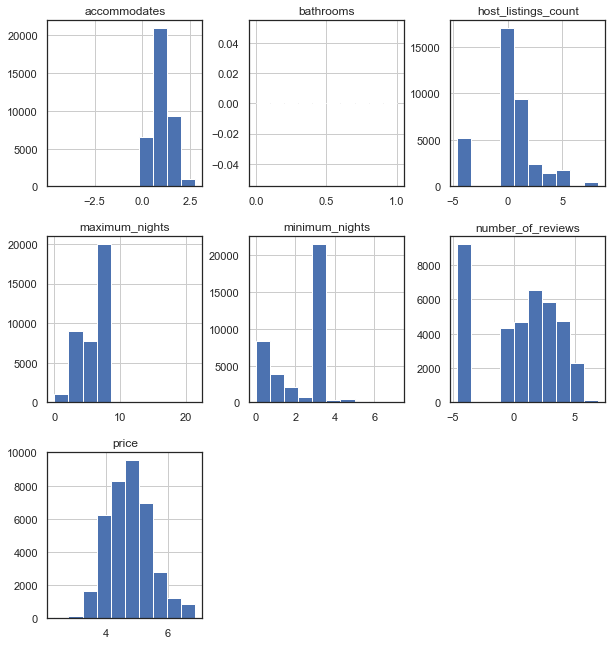

In [181]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [182]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

C:\Users\51370\anaconda3\envs\bigdata\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\51370\anaconda3\envs\bigdata\lib\site-packages\sklearn\utils\extmath.py:991: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
C:\Users\51370\anaconda3\envs\bigdata\lib\site-packages\sklearn\utils\extmath.py:1021: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


## Neural Network Building

In [183]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [184]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Time taken to run: 0.0 minutes

Training MSE: 0.1313
Validation MSE: 0.1814

Training r2: 0.7505
Validation r2: 0.6595


In [185]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
long_term_stays,0.000000
review_scores_communication_0-8/10,0.000000
review_scores_rating_0-79/100,0.000000
property_type_Other,0.000000
review_scores_location_0-8/10,0.000000
bathrooms,0.000000
bathrooms_text_8 baths,0.000000
bathrooms_text_7.5 baths,0.000000
bathrooms_text_7 baths,0.000000
bathrooms_text_6.5 baths,0.000000


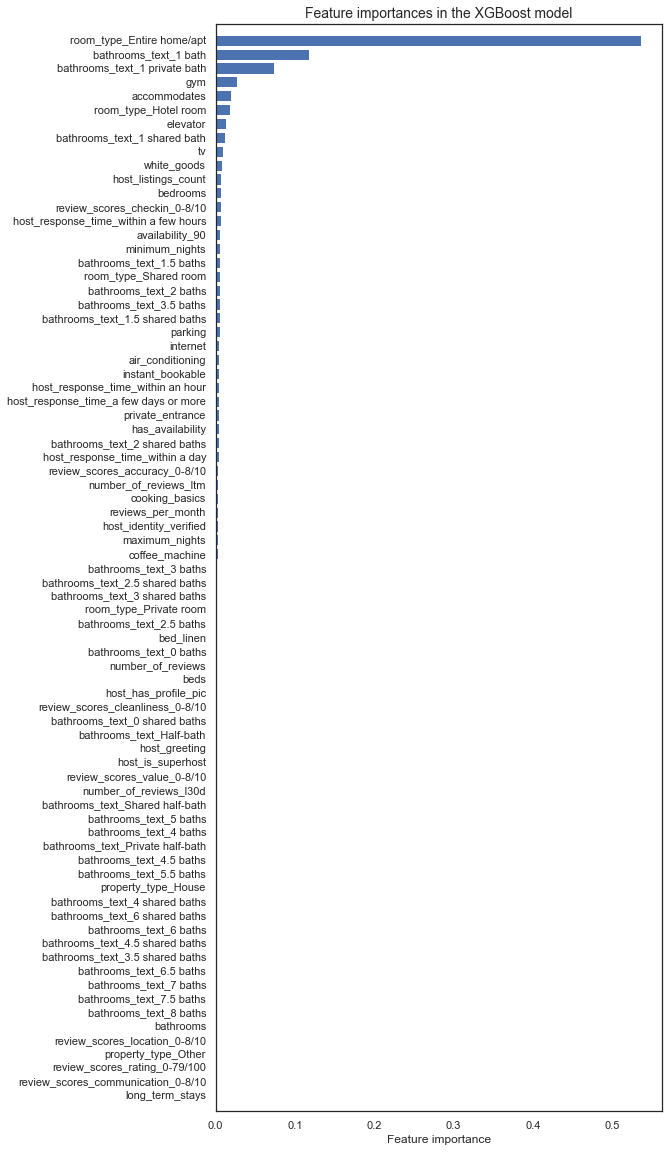

In [186]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

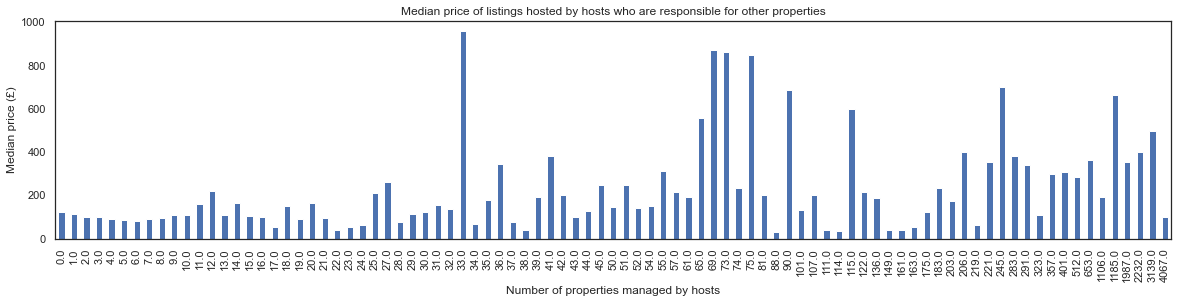

In [187]:
# Median price for different host listing counts
plt.figure()
df.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (£)');

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               9984      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 109,057
Trainable params: 109,057
Non-trainable params: 0
_________________________________________________________________
None


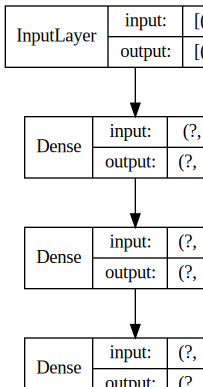

In [188]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [189]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Epoch 1/100
107/107 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/100
107/107 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/100
107/107 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/100
107/107 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/100
107/107 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/100
107/107 [==============================] - 0s 3ms/step - loss: nan - mean_squared_

In [190]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    # print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    # print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    # print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    # print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

In [191]:
nn_model_evaluation(nn2)

KeyError: 'loss'

In [ ]:
model = nn2
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
# print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
# print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
# print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
np.isnan(X)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,reviews_per_month,check_in_24h,air_conditioning,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,parking,host_greeting,internet,long_term_stays,private_entrance,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0%,host_response_rate_10%,host_response_rate_100%,room_type_Private room,review_scores_rating_0-79/100,review_scores_accuracy_0-8/10,review_scores_cleanliness_0-8/10,review_scores_checkin_0-8/10,review_scores_communication_0-8/10,review_scores_location_0-8/10,review_scores_value_0-8/10,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37708,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
37709,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
37710,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [ ]:
np.isnan(y_train.values.any())

False

In [ ]:
np.nan_to_num(X)

array([[-0.49238321,  0.73454995,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321, -0.10733174,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321, -0.10733174,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       ...,
       [-0.49238321,  0.86347897,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321,  2.07448521,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321,  2.07448521,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166]])

In [ ]:
X_train.fillna(X_train.mean())
X_test.fillna(X_test.mean())
y_test.fillna(y_test.mean())
y_train.fillna(y_train.mean())


id
41396507    4.007333
45924235    4.744932
9475136     4.499810
30396953    4.976734
568661      4.442651
              ...   
10043483    4.584967
22484057    3.555348
27677869    4.174387
45191374    4.465908
23188871    4.248495
Name: price, Length: 30170, dtype: float64